In [1]:
%matplotlib inline
import os
import re
import json
import operator
from collections import defaultdict

import yaml
import requests
import pandas
import matplotlib.pyplot as plt

API_URL = "https://api.jujucharms.com/charmstore/v5"

In [2]:
def filename(charmname, type):
    return "cached/{}/{}.json".format(type, charmname.replace('/',':'))


def cache_charm_list():
    resp = requests.get(API_URL + '/list?type=charm')
    charms = resp.json()['Results']
    with open('cached/charm-list-cached.json', 'w') as f:
        json.dump(charms, f, indent=4)


def get_charms():
    with open('cached/charm-list-cached.json', 'r') as f:
        charms = json.load(f)
    return [charm['Id'][3:] for charm in charms]


def cache_layer_files():
    charms = get_charms()
    numreactive = 0
    for name in charms:
        
        if os.path.isfile(filename(name, 'layer-yaml')):
            with open(filename(name, 'layer-yaml'), 'r') as f:
                if not "ArchiveDownloadCount" in f.read():
                    if "ceph" in name:
                        print(name)
                    continue
        else:
            continue
        print("getting doing charm {}".format(name))
        resp = requests.get("{}/{}/archive/layer.yaml".format(API_URL, name))
        if resp.status_code == 200:
            numreactive += 1
            layer = yaml.load(resp.text)
            with open(filename(name, 'layer-yaml'), 'w') as f:
                json.dump(layer, f, indent=4)
        else:
            os.remove(filename(name, 'layer-yaml'))
    print("Total charms: {}\nReactive charms: {}".format(len(charms), numreactive))

def get_layer_yaml(name):
    path = filename(name, 'layer-yaml')
    try:
        with open(path, 'r') as f:
            layer_yaml = json.load(f)
            return layer_yaml
    except:
        return None
    
def cache_metrics():
    charms = get_charms()
    for name in charms:
        if not os.path.isfile(filename(name, 'metrics')):
            resp = requests.get("{}/{}/meta/stats".format(API_URL, name))
            if resp.status_code == 200:
                layer = yaml.load(resp.text)
                with open(filename(name, 'metrics'), 'w') as f:
                    json.dump(layer, f, indent=4)

    
def get_metrics(name):
    path = filename(name, 'metrics')
    try:
        with open(path, 'r') as f:
            metrics = json.load(f)
            return metrics
    except:
        return None 

In [3]:
#cache_charm_list()
#cache_layer_files()
#cache_metrics()

In [3]:
def get_reactive_charms():
    reactive_charms = []
    for name in get_charms():
        if os.path.isfile(filename(name, 'layer-yaml')):
            reactive_charms.append(name)
    return reactive_charms
  

def remove_version(name):
    name = re.sub('(-[0-9]+$)', '', name)
    return name
    
    
def normalize(name):
    name = name.split('/')[-1]
    name = remove_version(name)
    return name


In [4]:
def get_grouped_includes(dependencies):
    '''converts a list of includes into two lists of includes: (layers, interfaces)
    '''
    layers = []
    interfaces = []
    for incl in dependencies or []:
        type, l_name = incl.split(':')
        if type in ('layer', 'cs'):
            layers.append(l_name)
        elif type == 'interface':
            interfaces.append(l_name)
        else:
            print("type {} not known".format(type))
    return (layers, interfaces)


charms = {k:{} for k in get_charms()}

for charm_name in charms:
    # If a charm has a layer.yaml file, it's a reactive charm
    # Add dependencies of the reactive charm
    layer_yaml = get_layer_yaml(charm_name)
    if layer_yaml:
        charms[charm_name]['reactive'] = True
        (
            charms[charm_name]['include-layers'],
            charms[charm_name]['include-interfaces'],
        ) = get_grouped_includes(layer_yaml.get('includes'))
    else:
        charms[charm_name]['reactive'] = False
        charms[charm_name]['include-layers'] = []
        charms[charm_name]['include-interfaces'] = []
        
    # Add the metrics for each charm
    charms[charm_name]['downloads-day'] = get_metrics(charm_name).get('ArchiveDownloadAllRevisions')['Day']
    charms[charm_name]['downloads-week'] = get_metrics(charm_name).get('ArchiveDownloadAllRevisions')['Week']
    charms[charm_name]['downloads-month'] = get_metrics(charm_name).get('ArchiveDownloadAllRevisions')['Month']
    charms[charm_name]['downloads-total'] = get_metrics(charm_name).get('ArchiveDownloadAllRevisions')['Total']
    
    # Add the normalized name for each charm
    charms[charm_name]['name-normalized'] = normalize(charm_name)
    
    # Add the versionless name for each charm
    charms[charm_name]['name-versionless'] = remove_version(charm_name)


# Get a table where rows, the keys from the dict are the index of the table    
charmstable = pandas.DataFrame.from_dict(charms, orient='index')
charmstable.sort_values('downloads-month', inplace=True, ascending=False)

charmstable.head()

,reactive,include-layers,include-interfaces,downloads-day,downloads-week,downloads-month,downloads-total,name-normalized,name-versionless
keystone-273,False,[],[],68,590,3233,113113,keystone,keystone
rabbitmq-server-70,False,[],[],68,592,3208,154702,rabbitmq-server,rabbitmq-server
percona-cluster-257,False,[],[],70,565,3125,78465,percona-cluster,percona-cluster
glance-261,False,[],[],68,580,3113,100037,glance,glance
nova-cloud-controller-304,False,[],[],71,585,3072,105079,nova-cloud-controller,nova-cloud-controller


In [5]:
versionless_charmstable = charmstable.groupby(
    'name-versionless'
).agg({
    'reactive': lambda x: x.max(),
    'include-layers': lambda x: list(set(x.sum())),
    'include-interfaces': lambda x: list(set(x.sum())),
    'downloads-day': lambda x: x[0],
    'downloads-week': lambda x: x[0],
    'downloads-month': lambda x: x[0],
    'downloads-total': lambda x: x[0],
    'name-normalized': lambda x: x[0],
})

versionless_charmstable.head()

versionless_charmstable.sort_values('downloads-month', inplace=True, ascending=False)
versionless_charmstable.head()

#versionless_charmstable.loc[versionless_charmstable['name-normalized'] == "mongodb"].head()

,reactive,include-layers,include-interfaces,downloads-day,downloads-week,downloads-month,downloads-total,name-normalized
name-versionless,,,,,,,,
keystone,False,[],[],68,590,3233,113113,keystone
rabbitmq-server,False,[],[],68,592,3208,154702,rabbitmq-server
percona-cluster,False,[],[],70,565,3125,78465,percona-cluster
glance,False,[],[],68,580,3113,100037,glance
nova-cloud-controller,False,[],[],71,585,3072,105079,nova-cloud-controller


In [6]:
# 

normalized_charmstable = versionless_charmstable.loc[
    versionless_charmstable['downloads-month'] >0        # remove all charms that aren't used
].groupby(     
    'name-normalized'                                    # Group by their charmname (without namespace)
).agg({
    'reactive': lambda x: x.max(),                       # If one of them is reactive, count them all as reactive
    'include-layers': lambda x: list(set(x.sum())),      # Merge all layer dependencies
    'include-interfaces': lambda x: list(set(x.sum())),  # Merge all interface dependencies
    'downloads-day': lambda x: x.sum(),                  # sum all downloads
    'downloads-week': lambda x: x.sum(),
    'downloads-month': lambda x: x.sum(),
    'downloads-total': lambda x: x.sum(),
})

normalized_charmstable.head()

normalized_charmstable.sort_values('downloads-month', inplace=True, ascending=False)
normalized_charmstable.head()


,reactive,include-layers,include-interfaces,downloads-day,downloads-week,downloads-month,downloads-total
name-normalized,,,,,,,
percona-cluster,False,[],[],115,1030,4953,130100
rabbitmq-server,False,[],[],102,999,4894,305092
glance,False,[],[],107,988,4726,176272
nova-cloud-controller,False,[],[],112,956,4499,192381
keystone,False,[],[],99,944,4431,205312


In [7]:
#
# Charms which are active (>0 downloads in last month)
#

activecharms = normalized_charmstable

print("Total Active Charms: {}"
      "\nRegular:             {}"
      "\nReactive:            {}"
      "\t({}%)".format(
          len(activecharms),
          len(activecharms.loc[activecharms['reactive'] == False]),
          len(activecharms.loc[activecharms['reactive'] == True]),
          activecharms['reactive'].mean()*100,
      )
)


Total Active Charms: 529
Regular:             353
Reactive:            176	(33.2703213610586%)


In [8]:
reactive_charm_names = normalized_charmstable.loc[normalized_charmstable['reactive'] == True].index.values

included_layers = defaultdict(lambda: defaultdict(list))
included_interfaces = defaultdict(lambda: defaultdict(list))

for charm_name in reactive_charm_names:
    charm = normalized_charmstable.loc[charm_name]
    for include_layer in charm['include-layers']:
        included_layers[include_layer]['charms'].append(charm_name)
    for include_interface in charm['include-interfaces']:
        included_interfaces[include_interface]['charms'].append(charm_name) 
        
included_layers = pandas.DataFrame.from_dict(included_layers, orient='index')
included_layers['num-charms'] = included_layers['charms'].apply(len)


included_interfaces = pandas.DataFrame.from_dict(included_interfaces, orient='index')
included_interfaces['num-charms'] = included_interfaces['charms'].apply(len)

included_layers.head()

,charms,num-charms
6wind-common,"[virtual-accelerator-network, virtual-accelera...",2
apache-bigtop-base,"[hadoop-plugin, hadoop-namenode, hadoop-slave,...",14
apache-flume-base,"[apache-flume-hdfs, apache-flume-kafka, apache...",3
apache-hadoop-datanode,[apache-hadoop-slave],1
apache-hadoop-nodemanager,[apache-hadoop-slave],1


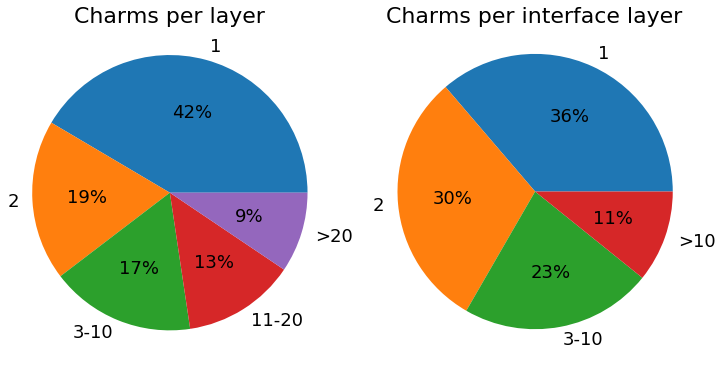

In [11]:
included_layer_buckets = pandas.cut(
    included_layers['num-charms'],
    [0,1,2,10,20,1000]
).value_counts(normalize=True)*100

included_interfaces_buckets = pandas.cut(
    included_interfaces['num-charms'],
    [0,1,2,10,50]
).value_counts(normalize=True)*100




fig = plt.figure(figsize=(12, 6))  # a new figure window
ax = fig.add_subplot(1, 2, 1) 
patches, texts, autotexts = ax.pie(
    included_layer_buckets,
    labels=['1','2','3-10','11-20','>20'],
    autopct='%1.f%%'
)
for t in texts + autotexts:
    t.set_size(18)
ax.axis('equal') 
ax.set_title("Charms per layer", fontsize=22)

ax = fig.add_subplot(1, 2, 2) 
patches, texts, autotexts = ax.pie(
    included_interfaces_buckets,
    labels=['1','2','3-10','>10'],
    autopct='%1.f%%'
)
for t in texts + autotexts:
    t.set_size(18)
ax.axis('equal') 
ax.set_title("Charms per interface layer", fontsize=22)

fig.savefig("layer-interface-usage.pdf", bbox_inches="tight")


In [12]:
normalized_charmstable['shared-interfaces'] = normalized_charmstable['include-interfaces'].apply(
    lambda x: [
        i_name for i_name in x
        if included_interfaces.loc[i_name]['num-charms'] > 1
    ])
normalized_charmstable['shared-layers'] = normalized_charmstable['include-layers'].apply(
    lambda x: [
        i_name for i_name in x
        if included_layers.loc[i_name]['num-charms'] > 1
    ])

normalized_charmstable.head()

,reactive,include-layers,include-interfaces,downloads-day,downloads-week,downloads-month,downloads-total,shared-interfaces,shared-layers
name-normalized,,,,,,,,,
percona-cluster,False,[],[],115,1030,4953,130100,[],[]
rabbitmq-server,False,[],[],102,999,4894,305092,[],[]
glance,False,[],[],107,988,4726,176272,[],[]
nova-cloud-controller,False,[],[],112,956,4499,192381,[],[]
keystone,False,[],[],99,944,4431,205312,[],[]


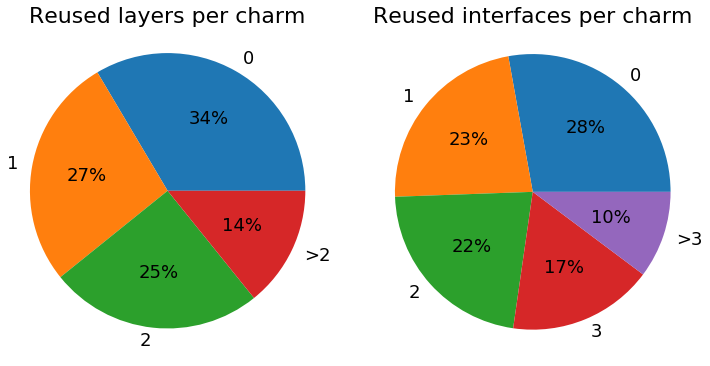

In [15]:
layer_percents = pandas.cut(
    normalized_charmstable.loc[
        activecharms['reactive'] == True
    ]['shared-layers'].apply(
        lambda x: len(x)
    ),
    [-1,1,2,3,100],
).value_counts(normalize=True)*100


interface_percents = pandas.cut(
    normalized_charmstable.loc[
        activecharms['reactive'] == True
    ]['shared-interfaces'].apply(
        lambda x: len(x)
    ),
    [-1,0,1,2,3,100],
).value_counts(normalize=True)*100




fig = plt.figure(figsize=(12, 6))  # a new figure window
ax = fig.add_subplot(1, 2, 1) 
patches, texts, autotexts = ax.pie(
    layer_percents,
    labels=['0','1','2','>2'],
    autopct='%1.f%%',
)
for t in texts + autotexts:
    t.set_size(18)
ax.axis('equal') 
ax.set_title("Reused layers per charm", fontsize=22)

ax = fig.add_subplot(1, 2, 2) 
patches, texts, autotexts = ax.pie(
    interface_percents,
    labels=['0', '1','2','3','>3'],
    autopct='%1.f%%',
)
for t in texts + autotexts:
    t.set_size(18)
ax.axis('equal') 
ax.set_title("Reused interfaces per charm", fontsize=22)


    
    

#ax.title, ax.xaxis.label, ax.yaxis.label] +
#             ax.get_xticklabels() + ax.get_yticklabels()


fig.savefig("charm-layer-usage.pdf", bbox_inches="tight")